# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time
from collections import Counter

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

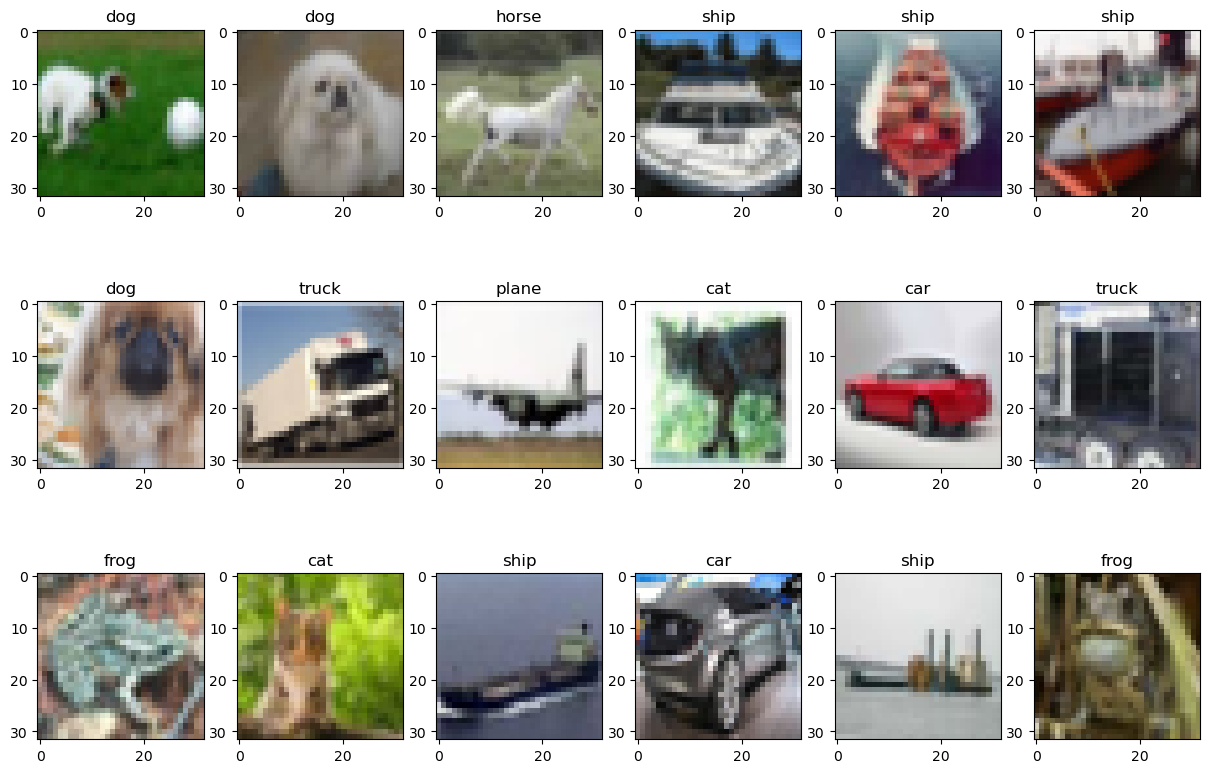

In [32]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, len(x_train))
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx][0])])
plt.show()

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

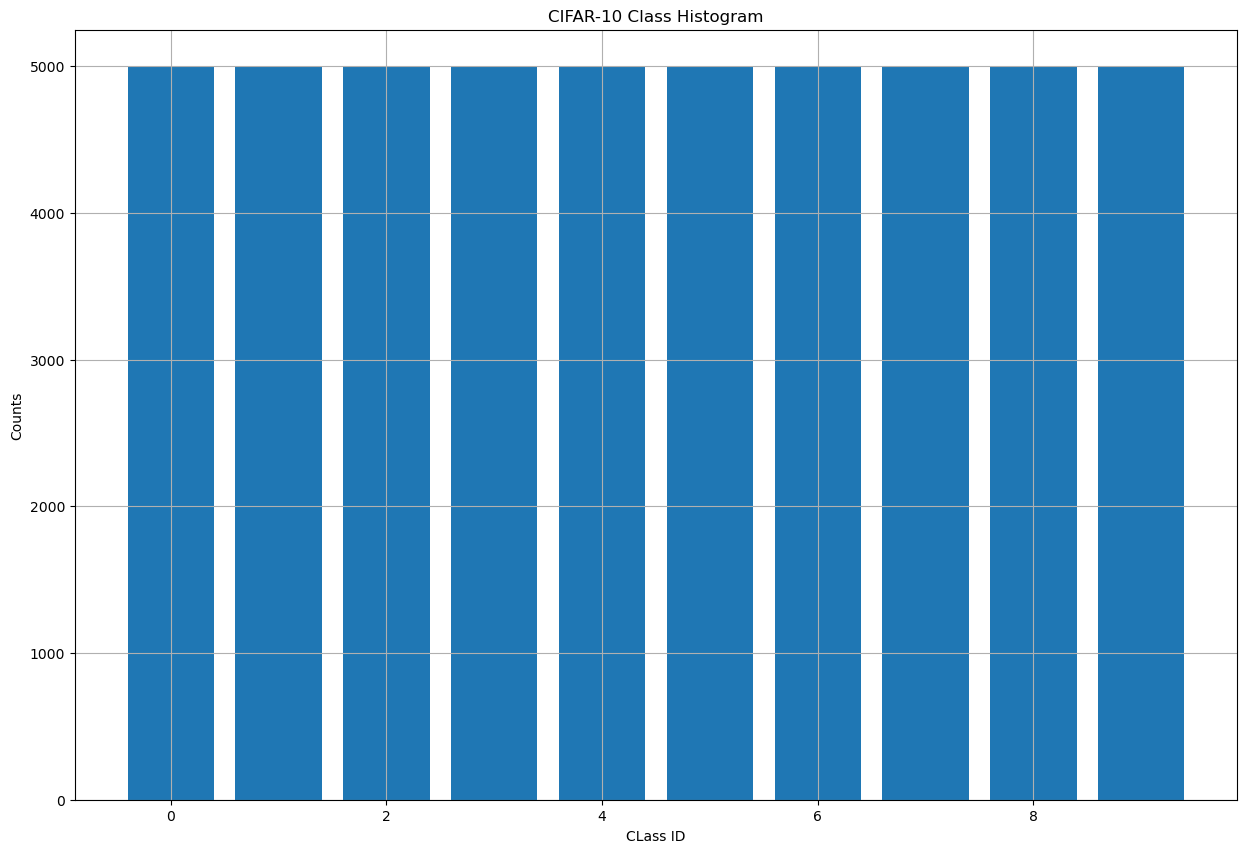

Class counts:  {np.uint8(6): 5000, np.uint8(9): 5000, np.uint8(4): 5000, np.uint8(1): 5000, np.uint8(2): 5000, np.uint8(7): 5000, np.uint8(8): 5000, np.uint8(3): 5000, np.uint8(5): 5000, np.uint8(0): 5000}


In [33]:
# Compute the class histogram
ids = y_train.flatten()
hist = Counter(ids)
plt.bar(hist.keys(),hist.values())
plt.grid(True)
plt.xlabel('CLass ID')
plt.ylabel('Counts')
plt.title('CIFAR-10 Class Histogram')
plt.show()
print("Class counts: ", dict(hist))

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [34]:
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [35]:
inputs = Input(shape=(size,size,3))
x = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Build the classifier
model = Model(inputs, outputs)

# Show the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,962 (601.41 KB)

 Trainable params: 153,962 (601.41 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [37]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time()
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_split=0.2, verbose=1)
print(f"Training time: {time() - start_time:.2f} seconds")

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8253 - loss: 0.5145 - val_accuracy: 0.6574 - val_loss: 1.1803
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8278 - loss: 0.5047 - val_accuracy: 0.6496 - val_loss: 1.2406
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8300 - loss: 0.4960 - val_accuracy: 0.6452 - val_loss: 1.2735
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8342 - loss: 0.4851 - val_accuracy: 0.6545 - val_loss: 1.2650
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8385 - loss: 0.4720 - val_accuracy: 0.6553 - val_loss: 1.2650
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8438 - loss: 0.4584 - val_accuracy: 0.6551 - val_loss: 1.2817
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8492 - loss: 0.4434 - val_accuracy: 0.6492 - val_loss: 1.3293
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8558 - loss: 0.4262 - val_accuracy: 0.

Train Acc      0.9309750199317932
Validation Acc 0.6324999928474426


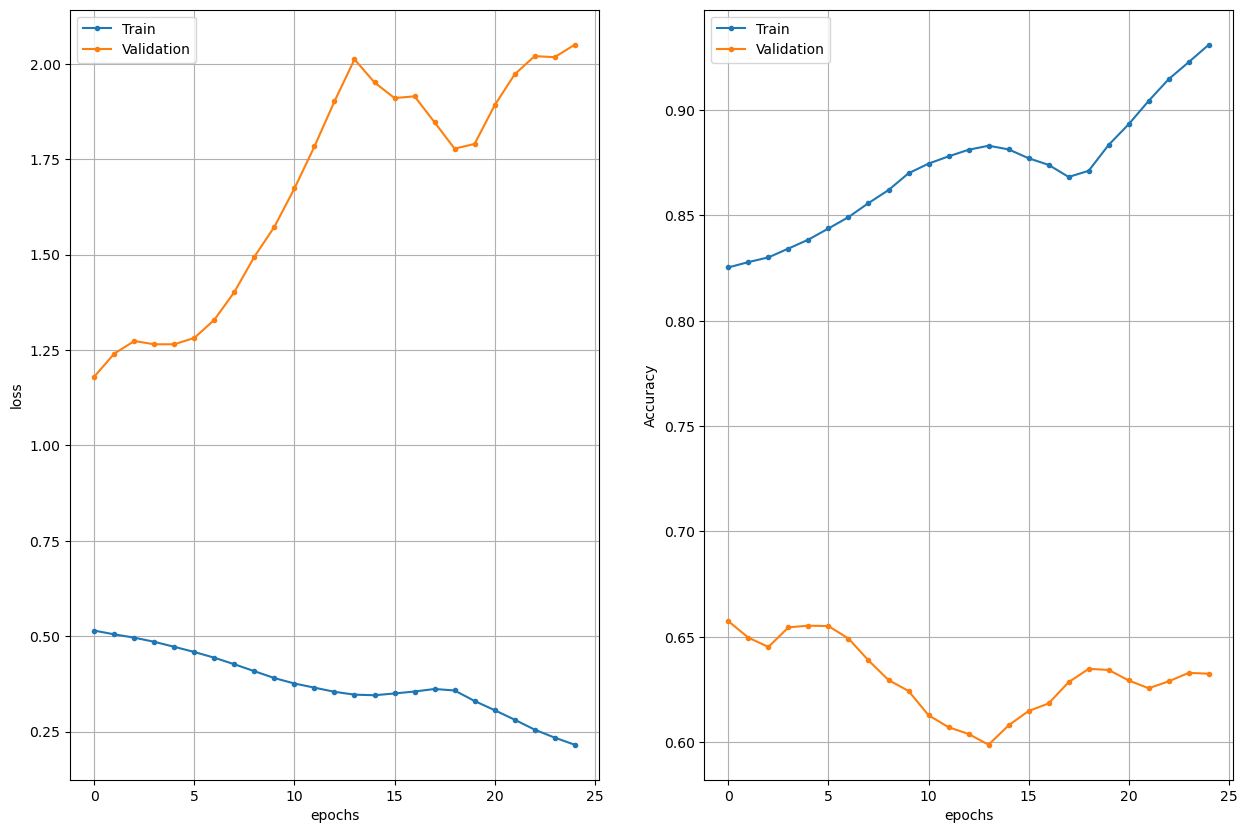

In [41]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [42]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


In [43]:
# Compute and print the accuracy for each class
from sklearn.metrics import accuracy_score
for class_id, class_name in classes.items():
    mask = (y_true == class_id)
    acc = accuracy_score(y_true[mask], y_pred[mask]) if mask.sum() > 0 else 0
    print(class_name, acc)

plane 0.74
car 0.803
bird 0.484
cat 0.285
deer 0.627
dog 0.485
frog 0.771
horse 0.756
ship 0.71
truck 0.618


In [44]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 2.0740
Test loss   2.0740461349487305
Test metric 0.6279000043869019


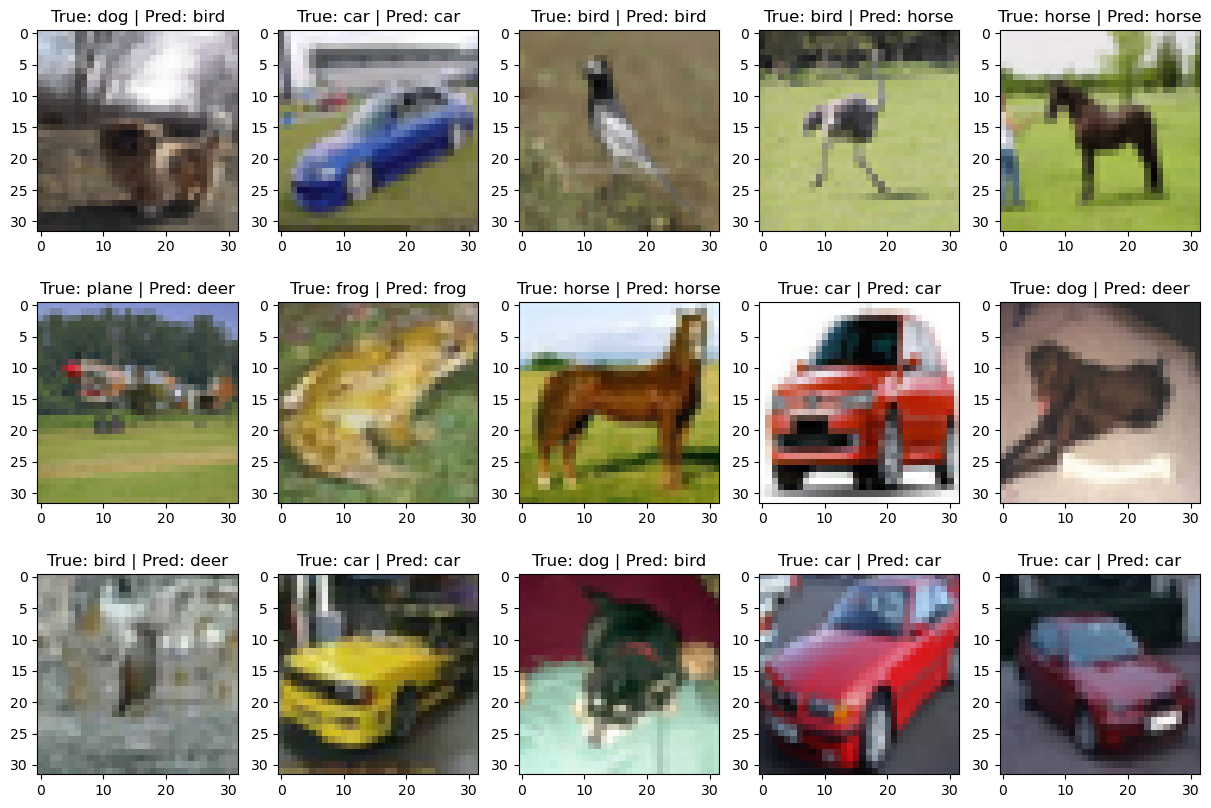

In [45]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
  A: As defined in the step 4 - the overall accuracy for the classifier is (Test metric) 0.617.
* What modifications would you do in order to improve the classification accuracy?
  A: probably, add more convolutional layers (16,32,64 filters), longer train with more Epochs, adjusting Adam's learning rate, and flip/rotate images. 
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?
  A: answered in Homework14_3d_question.ipynb